Traffic sign classifcation
====================

\#Convolutional Neural Network  
\#LISA dataset  
\#Keras  
\#iOS coreML

In [17]:
import numpy as np
from skimage import io, color, exposure, transform
from sklearn.cross_validation import train_test_split
import os
import glob
import h5py

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json, load_model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

from keras.optimizers import SGD
from keras.utils import np_utils
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras import backend as K
K.set_image_data_format('channels_last')

from matplotlib import pyplot as plt
%matplotlib inline

NUM_CLASSES = 43
IMG_SIZE = 48

## Preprocess image  
1. equalize histogram
2. central scrop
3. rescale to 32x32

In [18]:
def preprocess_img(img):
    hsv = color.rgb2hsv(img)
    hsv[:,:,2] = exposure.equalize_hist(hsv[:,:,2])
    img = color.hsv2rgb(hsv)

    min_side = min(img.shape[:-1])
    centre = img.shape[0]//2, img.shape[1]//2
    img = img[centre[0]-min_side//2:centre[0]+min_side//2,
              centre[1]-min_side//2:centre[1]+min_side//2,
              :]

    img = transform.resize(img, (IMG_SIZE, IMG_SIZE))

    return img


def get_class(img_path):
    return int(img_path.split('/')[1])

## Collect training set
The data was collected from LISA traffic sign data set, we would store the training data into X.h5 file in order to speed up next the process next time.  
http://cvrr.ucsd.edu/LISA/lisa-traffic-sign-dataset.html

In [19]:
try:
    with  h5py.File('X.h5') as hf: 
        X, y = hf['imgs'][:], hf['labels'][:]
    print("Loaded images from X.h5")
    
except (IOError,OSError, KeyError):  
    print("Error in reading X.h5. Processing all images...")
    root_dir = 'gtsrb_training/'
    imgs = []
    labels = []
    all_img_paths = glob.glob(os.path.join(root_dir, '*/*.ppm'))
    np.random.shuffle(all_img_paths)
    for img_path in all_img_paths:
        try:
            img = preprocess_img(io.imread(img_path))
            label = get_class(img_path)
            imgs.append(img)
            labels.append(label)

            if len(imgs)%1000 == 0: print("Processed {0}/{1}".format(len(imgs), len(all_img_paths)))
        except (IOError, OSError):
            print('missed', img_path)
            pass

    X = np.array(imgs, dtype='float32')
    y = np.eye(NUM_CLASSES, dtype='uint8')[labels]
    with h5py.File('X.h5','w') as hf:
        hf.create_dataset('imgs', data=X)
        hf.create_dataset('labels', data=y)

Error in reading X.h5. Processing all images...


/home/allenhsu/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Processed 1000/39209
Processed 2000/39209
Processed 3000/39209
Processed 4000/39209
Processed 5000/39209
Processed 6000/39209
Processed 7000/39209
Processed 8000/39209
Processed 9000/39209
Processed 10000/39209
Processed 11000/39209
Processed 12000/39209
Processed 13000/39209
Processed 14000/39209
Processed 15000/39209
Processed 16000/39209
Processed 17000/39209
Processed 18000/39209
Processed 19000/39209
Processed 20000/39209
Processed 21000/39209
Processed 22000/39209
Processed 23000/39209
Processed 24000/39209
Processed 25000/39209
Processed 26000/39209
Processed 27000/39209
Processed 28000/39209
Processed 29000/39209
Processed 30000/39209
Processed 31000/39209
Processed 32000/39209
Processed 33000/39209
Processed 34000/39209
Processed 35000/39209
Processed 36000/39209
Processed 37000/39209
Processed 38000/39209
Processed 39000/39209


## Model architecture
1. 6 convolutional layers with 3 max-pool and drop-out layers  
2. 1 fully-connected layer to collect the features  
3. Collect the result by softmax

In [20]:
def cnn_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=(IMG_SIZE, IMG_SIZE, 3),
                     activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), padding='same',
                     activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3), padding='same',
                     activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    return model

model = cnn_model()
lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
          optimizer=sgd,
          metrics=['accuracy'])


def lr_schedule(epoch):
    return lr*(0.1**int(epoch/10))

## Train the model

In [21]:
batch_size = 128
nb_epoch = 30

history = model.fit(X, y,
                  batch_size=batch_size,
                  epochs=nb_epoch,
                  validation_split=0.2,
                  shuffle=True,
                  callbacks=[LearningRateScheduler(lr_schedule),
                            ModelCheckpoint('model.h5',save_best_only=True)])

Train on 31367 samples, validate on 7842 samples
Epoch 1/30
31367/31367 [==============================] - 19s 596us/step - loss: 3.0989 - acc: 0.1764 - val_loss: 1.6791 - val_acc: 0.4960
Epoch 2/30
31367/31367 [==============================] - 18s 563us/step - loss: 0.9108 - acc: 0.7150 - val_loss: 0.2547 - val_acc: 0.9218
Epoch 3/30
31367/31367 [==============================] - 17s 558us/step - loss: 0.3556 - acc: 0.8867 - val_loss: 0.3231 - val_acc: 0.8959
Epoch 4/30
31367/31367 [==============================] - 18s 559us/step - loss: 0.2307 - acc: 0.9268 - val_loss: 0.6407 - val_acc: 0.7983
Epoch 5/30
31367/31367 [==============================] - 18s 558us/step - loss: 0.2025 - acc: 0.9363 - val_loss: 0.0633 - val_acc: 0.9815
Epoch 6/30
31367/31367 [==============================] - 18s 564us/step - loss: 0.1273 - acc: 0.9594 - val_loss: 0.0462 - val_acc: 0.9857
Epoch 7/30
31367/31367 [==============================] - 18s 571us/step - loss: 0.1047 - acc: 0.9674 - val_loss: 0.0

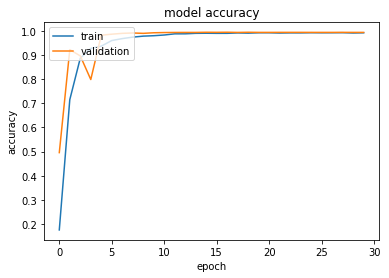

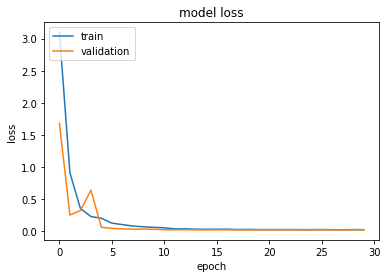

In [33]:
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('acc_f.png', format='png', dpi=300)
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('loss_f.png', format='png', dpi=300)
plt.show()

In [28]:
import pandas as pd
test_info = pd.read_csv('GT-final_test.csv', sep=';')
root_dir = 'gtsrb_testing/'
X_test = []
y_test = []
for file_name, class_id  in zip(list(test_info['Filename']), list(test_info['ClassId'])):
    img_path = os.path.join('gtsrb_testing/',file_name)
    X_test.append(preprocess_img(io.imread(img_path)))
    y_test.append(class_id)
    if len(X_test)%1000 == 0: print("Processed {0}".format(len(X_test)))


X_test = np.array(X_test)
y_test = np.array(y_test)

/home/allenhsu/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Processed 1000
Processed 2000
Processed 3000
Processed 4000
Processed 5000
Processed 6000
Processed 7000
Processed 8000
Processed 9000
Processed 10000
Processed 11000
Processed 12000


In [29]:
y_pred = model.predict_classes(X_test)
acc = np.sum(y_pred==y_test)/np.size(y_pred)
print("Test accuracy = {}".format(acc))

Test accuracy = 0.9630245447347585


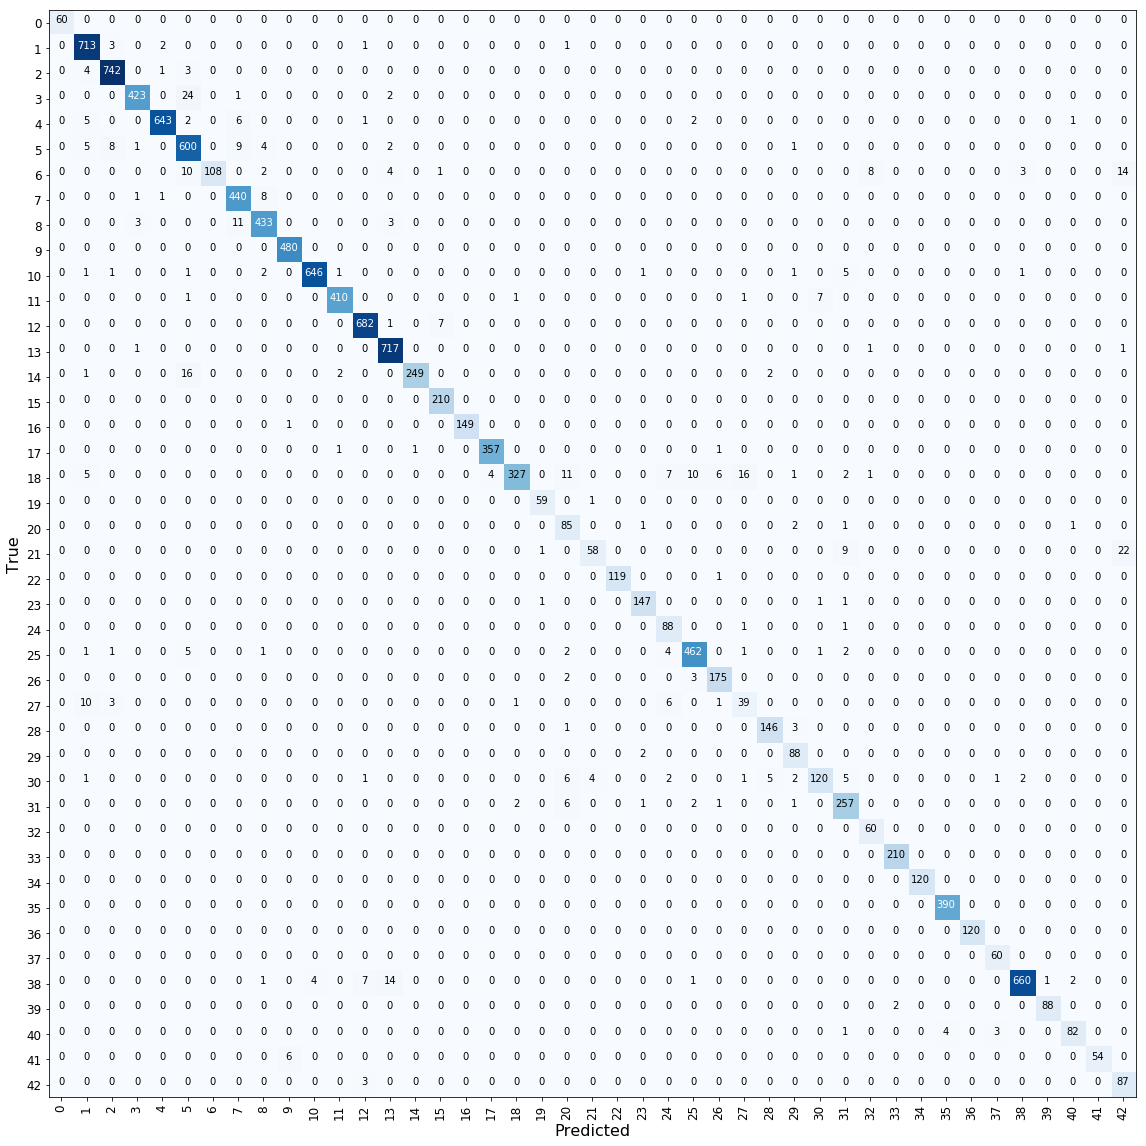

In [37]:
from sklearn.metrics import confusion_matrix
import itertools
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(20,20))  
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
tick_marks = np.arange(NUM_CLASSES)

plt.xticks(range(NUM_CLASSES))
plt.yticks(range(NUM_CLASSES))
plt.xticks(rotation= 90)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Predicted', fontsize = 16)
plt.ylabel('True', fontsize= 16)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.savefig('confusion_matrix.png', format='png', dpi=300)
plt.show()


## Train with augmented dataset

Using ImageDataGenerator to augment the training data  
*  Sample-wise standardization  
* Feature-wise standardization  
* ZCA whitening  
* Random rotation, shifts, shear and flips  
* Dimension reordering  


In [30]:
from sklearn.cross_validation import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

datagen = ImageDataGenerator(featurewise_center=False, 
                             featurewise_std_normalization=False, 
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10.,)

datagen.fit(X_train)

In [31]:
model_aug = cnn_model()
lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model_aug.compile(loss='categorical_crossentropy',
          optimizer=sgd,
          metrics=['accuracy'])


def lr_schedule(epoch):
    return lr*(0.1**int(epoch/10))

In [32]:
nb_epoch = 20
history = model_aug.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                                    steps_per_epoch=X_train.shape[0],
                                    epochs=nb_epoch,
                                    validation_data=(X_val, y_val),
                                    callbacks=[LearningRateScheduler(lr_schedule),
                                               ModelCheckpoint('model.h5',save_best_only=True)])

Epoch 1/20
31367/31367 [==============================] - 2134s 68ms/step - loss: 0.1022 - acc: 0.9692 - val_loss: 0.0029 - val_acc: 0.9994
Epoch 2/20
31367/31367 [==============================] - 2125s 68ms/step - loss: 0.0054 - acc: 0.9983 - val_loss: 0.0021 - val_acc: 0.9995
Epoch 3/20
31367/31367 [==============================] - 2121s 68ms/step - loss: 0.0030 - acc: 0.9991 - val_loss: 0.0013 - val_acc: 0.9996
Epoch 4/20
31367/31367 [==============================] - 2114s 67ms/step - loss: 0.0019 - acc: 0.9994 - val_loss: 0.0014 - val_acc: 0.9995
Epoch 5/20
20329/31367 [==================>...........] - ETA: 12:30 - loss: 0.0016 - acc: 0.9995

KeyboardInterrupt: 

In [14]:
y_pred = model_aug.predict_classes(X_test)
acc = np.sum(y_pred==y_test)/np.size(y_pred)
print("Test accuracy = {}".format(acc))

Test accuracy = 0.9950657894736842


In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 7200)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               1843456   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 14)                3598      
Total para

## Training result with plot and confusion matrix

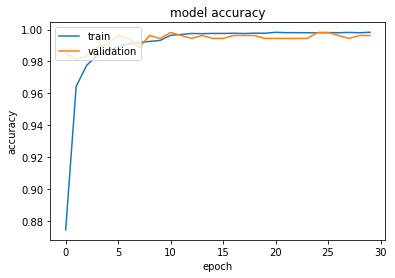

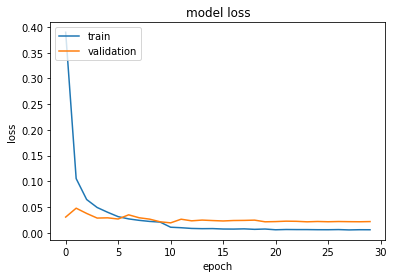

In [16]:
#  "Accuracy"
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('model_accuracy.svg', format='svg', dpi=300)
plt.show()
# "Loss"
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('model_loss.svg', format='svg', dpi=300)
plt.show()

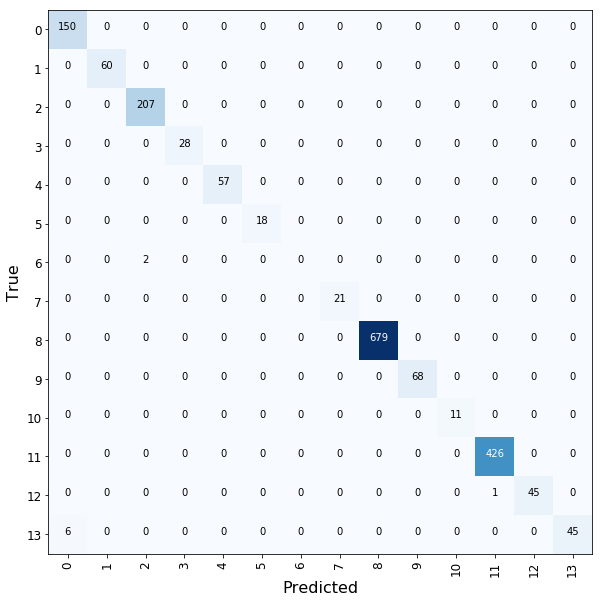

In [17]:
from sklearn.metrics import confusion_matrix
import itertools
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10,10))  
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
tick_marks = np.arange(NUM_CLASSES)

plt.xticks(range(NUM_CLASSES))
plt.yticks(range(NUM_CLASSES))
plt.xticks(rotation=90)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Predicted', fontsize = 16)
plt.ylabel('True', fontsize= 16)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.savefig('confusion_matrix.svg',  format='svg', dpi=300)
plt.show()


## Save the model and convert the Keras model into coreML for iOS

In [24]:
model_aug.save("traffic_sign_classifier_model.h5")

In [5]:
model_aug = load_model("traffic_sign_classifier_model.h5")

In [6]:
import coremltools
coreml_model = coremltools.converters.keras.convert(model_aug, input_names='image',
                                                    image_input_names='image',
                                                    image_scale=1/255.0,
                                                    class_labels=['speedLimit25', 'speedLimit30', 'speedLimit35', 'speedLimit40', 'speedLimit45', 'speedLimit50', 'speedLimit55', 'speedLimit65', 'stop', 'stopAhead', 'slow', 'pedestrianCrossing', 'school', 'schoolSpeedLimit25'])
#                                                     class_labels=[i for i in range(14)])
coreml_model.save('traffic_sign_classifier_model.mlmodel')

0 : conv2d_21_input, <keras.engine.topology.InputLayer object at 0x7f969e0edb38>
1 : conv2d_21, <keras.layers.convolutional.Conv2D object at 0x7f969e0ed748>
2 : conv2d_21__activation__, <keras.layers.core.Activation object at 0x7f96ae298208>
3 : conv2d_22, <keras.layers.convolutional.Conv2D object at 0x7f969e0edda0>
4 : conv2d_22__activation__, <keras.layers.core.Activation object at 0x7f96ae298470>
5 : max_pooling2d_11, <keras.layers.pooling.MaxPooling2D object at 0x7f969e0edc88>
6 : conv2d_23, <keras.layers.convolutional.Conv2D object at 0x7f969e09f400>
7 : conv2d_23__activation__, <keras.layers.core.Activation object at 0x7f96ae2984e0>
8 : conv2d_24, <keras.layers.convolutional.Conv2D object at 0x7f969e08e4a8>
9 : conv2d_24__activation__, <keras.layers.core.Activation object at 0x7f96ae2983c8>
10 : max_pooling2d_12, <keras.layers.pooling.MaxPooling2D object at 0x7f969e0bcb00>
11 : conv2d_25, <keras.layers.convolutional.Conv2D object at 0x7f969e05cf98>
12 : conv2d_25__activation__, <